# Imports

In [83]:
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
import seaborn as sns

from sklearn.impute import IterativeImputer

from scipy.stats import chi2_contingency

import pandas as pd

In [52]:
import plotly.io as pio

pio.renderers.default = "notebook"

# Reading data

In [53]:
train_data = pl.read_csv("data/train.csv")
train_data.head()

RowId,PlanType,CreditScore,RiskRating,PolicyStart,PropertyType,MaritalStatus,JobRole,Feedback,ResidenceType,EarningsBracket,HealthIndex,VehicleAge,Smoking,CustomerAge,PrevClaims,Sex,PolicyTenure,VitalityMetric,AssetMaturity,EngagementLevel,BaselineIndex,Dependents,ExerciseFreq,EducationLevel,AnnualIncome,Premium
i64,str,f64,f64,str,str,str,str,str,str,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,f64,f64
0,"""Premium""",null,null,"""2022-02-27 15:21:39.145732""","""House""","""Divorced""",null,"""Poor""","""Urban""",1385.682772,20.876754,16.0,"""Yes""",54.0,1.0,"""Female""",3.0,20.572226,11.925213,-0.645698,0.44069,4.0,"""Daily""","""Master's""",1132.0,111.0
1,"""Comprehensive""",502.0,501.23334,"""2022-04-03 15:21:39.082499""","""Apartment""","""Married""","""Employed""","""Average""","""Rural""",46626.023084,42.14238,1.0,"""Yes""",35.0,2.0,"""Male""",7.0,42.50956,3.34513,1.333364,0.186862,1.0,"""Monthly""","""PhD""",44954.0,45.0
2,"""Premium""",336.0,338.286834,"""2021-03-14 15:21:39.181605""","""Apartment""","""Single""",null,"""Good""","""Rural""",114656.072717,14.673932,17.0,"""Yes""",50.0,null,"""Male""",1.0,15.39453,12.21905,1.529187,0.353998,0.0,"""Monthly""","""PhD""",111000.0,33.0
3,"""Basic""",534.0,532.539677,"""2022-04-24 15:21:39.147735""","""House""",null,"""Unemployed""","""Good""","""Suburban""",15894.914059,33.792235,10.0,"""No""",56.0,null,"""Male""",8.0,null,9.384729,-1.215418,0.364996,4.0,"""Monthly""","""Bachelor's""",14894.0,23.0
4,"""Comprehensive""",751.0,747.198003,"""2024-05-28 15:21:39.132191""","""Apartment""","""Married""","""Employed""","""Average""","""Rural""",31103.694049,48.965705,10.0,null,28.0,null,"""Female""",4.0,48.142136,7.65065,-0.026876,0.526036,null,"""Monthly""","""PhD""",30959.0,105.0


I check how the data looks like. I also look at basic metrics as mean, standard deviation, number of missing values for feature, in order to spot potential problems. I see that there are a lot of missing values, which may be a problem. I also note there there is time feature, that needs mapping into natural numbers.

In [54]:
train_data.describe()

statistic,RowId,PlanType,CreditScore,RiskRating,PolicyStart,PropertyType,MaritalStatus,JobRole,Feedback,ResidenceType,EarningsBracket,HealthIndex,VehicleAge,Smoking,CustomerAge,PrevClaims,Sex,PolicyTenure,VitalityMetric,AssetMaturity,EngagementLevel,BaselineIndex,Dependents,ExerciseFreq,EducationLevel,AnnualIncome,Premium
str,f64,str,f64,f64,str,str,str,str,str,str,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,f64,f64
"""count""",720001.0,"""705672""",608623.0,618026.0,"""702026""","""705719""","""694588""","""494849""","""659834""","""705543""",672105.0,655194.0,698476.0,"""705486""",687655.0,486190.0,"""705582""",698395.0,655101.0,698390.0,698425.0,698218.0,634274.0,"""705634""","""705656""",662392.0,720001.0
"""null_count""",0.0,"""14329""",111378.0,101975.0,"""17975""","""14282""","""25413""","""225152""","""60167""","""14458""",47896.0,64807.0,21525.0,"""14515""",32346.0,233811.0,"""14419""",21606.0,64900.0,21611.0,21576.0,21783.0,85727.0,"""14367""","""14345""",57609.0,0.0
"""mean""",360000.0,null,597.846137,597.919747,null,null,null,null,null,null,34402.460475,25.634673,9.578541,null,41.157743,1.002437,null,5.016118,25.90154,8.161357,0.000749,0.499937,2.008091,null,null,32265.115394,1102.496065
"""std""",207846.529921,null,155.84515,177.69033,null,null,null,null,null,null,34442.038046,12.203883,5.777866,null,13.546206,0.983662,null,2.593778,13.124499,4.245716,1.001407,0.288684,1.417829,null,null,33247.783231,864.860519
"""min""",0.0,"""Basic""",125.0,297.79085,"""2019-08-17 15:21:39.080371""","""Apartment""","""Divorced""","""Employed""","""Average""","""Rural""",233.278281,2.012237,0.0,"""No""",18.0,0.0,"""Female""",1.0,0.654926,-0.63138,-4.839676,0.000005,0.0,"""Daily""","""Bachelor's""",1.0,20.0
"""25%""",180000.0,null,473.0,468.799773,null,null,null,null,null,null,8492.302465,15.927302,5.0,null,30.0,0.0,null,3.0,15.953126,4.73178,-0.676921,0.249874,1.0,null,null,7892.0,514.0
"""50%""",360000.0,null,601.0,594.953496,null,null,null,null,null,null,25002.341181,24.611017,10.0,null,41.0,1.0,null,5.0,24.604954,8.153803,-0.000381,0.500108,2.0,null,null,23590.0,872.0
"""75%""",540000.0,null,724.0,719.623432,null,null,null,null,null,null,46346.788559,34.564152,15.0,null,53.0,2.0,null,7.0,34.656811,11.476747,0.677325,0.749927,3.0,null,null,43943.0,1509.0
"""max""",720000.0,"""premium""",2035.2,2698.853242,"""2024-08-15 15:21:39.287115""","""house""","""single""","""Unemployed""","""Poor""","""urban""",507939.365323,58.569689,19.0,"""yes""",64.0,8.0,"""male""",9.0,172.906959,52.138145,5.057544,1.0,4.0,"""weekly""","""master's""",599840.0,4997.0


In [55]:
test_data = pl.read_csv("data/test.csv")
test_data.head()

RowId,PlanType,CreditScore,RiskRating,PolicyStart,PropertyType,MaritalStatus,JobRole,Feedback,ResidenceType,EarningsBracket,HealthIndex,VehicleAge,Smoking,CustomerAge,PrevClaims,Sex,PolicyTenure,VitalityMetric,AssetMaturity,EngagementLevel,BaselineIndex,Dependents,ExerciseFreq,EducationLevel,AnnualIncome
i64,str,f64,f64,str,str,str,str,str,str,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,f64
2000000,"""Comprehensive""",432.0,432.404298,"""2020-10-15 15:21:39.257696""","""House""","""Divorced""",null,null,"""Urban""",57113.404851,33.009849,9.0,"""yes""",56.0,0.0,"""Male""",7.0,32.763937,8.129452,-1.257546,0.522614,2.0,"""Monthly""","""High School""",54924.0
2000001,"""Comprehensive""",null,null,"""2020-09-19 15:21:39.269494""","""Condo""","""Divorced""",null,"""Good""","""Urban""",10698.259985,null,8.0,"""Yes""",46.0,null,"""Male""",6.0,null,7.299301,0.141176,0.083083,1.0,"""Monthly""","""Bachelor's""",10046.0
2000002,"""Basic""",501.0,500.950661,"""2020-10-03 15:21:39.237118""","""Condo""","""Married""","""Unemployed""","""Average""","""Rural""",71505.063357,12.746374,0.0,"""Yes""",58.0,null,"""Male""",6.0,13.110149,1.793606,1.481026,0.177211,null,"""Rarely""","""Bachelor's""",67782.0
2000003,"""Comprehensive""",642.0,641.329093,"""2023-04-10 15:21:39.207847""","""Condo""","""Single""",null,"""Poor""","""Rural""",1596.560354,9.868688,2.0,"""No""",null,2.0,"""Female""",2.0,8.812215,1.396501,-0.454844,0.283264,0.0,"""Daily""","""Master's""",1301.0
2000004,"""Comprehensive""",584.0,582.282418,"""2022-08-29 15:21:39.222387""","""House""","""Single""","""Employed""","""Average""","""Urban""",20891.123631,48.662292,2.0,"""Yes""",57.0,null,"""Female""",7.0,48.436315,3.734468,null,0.626154,3.0,"""Weekly""","""high school""",19473.0


In [56]:
test_data.describe()

statistic,RowId,PlanType,CreditScore,RiskRating,PolicyStart,PropertyType,MaritalStatus,JobRole,Feedback,ResidenceType,EarningsBracket,HealthIndex,VehicleAge,Smoking,CustomerAge,PrevClaims,Sex,PolicyTenure,VitalityMetric,AssetMaturity,EngagementLevel,BaselineIndex,Dependents,ExerciseFreq,EducationLevel,AnnualIncome
str,f64,str,f64,f64,str,str,str,str,str,str,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,f64
"""count""",359999.0,"""352545""",304635.0,309356.0,"""351062""","""352743""","""347352""","""248079""","""329780""","""352465""",336469.0,327586.0,349232.0,"""352892""",343603.0,243671.0,"""352302""",349183.0,327728.0,349168.0,349201.0,349223.0,317536.0,"""352740""","""352751""",331319.0
"""null_count""",0.0,"""7454""",55364.0,50643.0,"""8937""","""7256""","""12647""","""111920""","""30219""","""7534""",23530.0,32413.0,10767.0,"""7107""",16396.0,116328.0,"""7697""",10816.0,32271.0,10831.0,10798.0,10776.0,42463.0,"""7259""","""7248""",28680.0
"""mean""",2.7667e6,null,597.169019,597.033482,null,null,null,null,null,null,34247.173047,25.640841,9.563622,null,41.11577,1.003689,null,5.021739,25.913787,8.15208,-0.003411,0.499358,2.012317,null,null,32092.525074
"""std""",503278.922376,null,155.783133,176.916779,null,null,null,null,null,null,34270.406288,12.21807,5.773788,null,13.530449,0.981734,null,2.593866,13.139937,4.248413,1.002887,0.288686,1.417264,null,null,33076.364966
"""min""",2e6,"""Basic""",125.0,298.879273,"""2019-08-17 15:21:39.082499""","""Apartment""","""Divorced""","""Employed""","""Average""","""Rural""",240.444054,2.053458,0.0,"""No""",18.0,0.0,"""Female""",1.0,1.022711,-0.570355,-4.477288,9.3429e-7,0.0,"""Daily""","""Bachelor's""",2.0
"""25%""",2.09e6,null,472.0,468.070351,null,null,null,null,null,null,8524.228162,15.92497,5.0,null,30.0,0.0,null,3.0,15.959304,4.726344,-0.680273,0.249554,1.0,null,null,7916.0
"""50%""",3.059999e6,null,598.0,593.633623,null,null,null,null,null,null,24923.675835,24.619287,10.0,null,41.0,1.0,null,5.0,24.627818,8.123172,-0.002683,0.499259,2.0,null,null,23470.0
"""75%""",3.149999e6,null,723.0,718.988276,null,null,null,null,null,null,46252.361729,34.569356,15.0,null,53.0,2.0,null,7.0,34.677072,11.473144,0.672863,0.749581,3.0,null,null,43901.0
"""max""",3.239998e6,"""premium""",2037.6,2705.049619,"""2024-08-15 15:21:39.287115""","""house""","""single""","""Unemployed""","""Poor""","""urban""",506015.561509,58.975914,19.0,"""yes""",64.0,8.0,"""male""",9.0,169.67928,51.577866,4.486369,1.0,4.0,"""weekly""","""master's""",599984.0


## Data transformations

Here I map datetime to ordered numbers, so that ordinal relation can be learned by model.

In [57]:
train_data = train_data.with_columns(
    pl.col("PolicyStart").str.to_datetime().dt.date().cast(pl.Int64),
).with_columns(
    pl.col(pl.String).str.to_lowercase(),
)

# Distribution of the parameters

In [58]:
target_feature = "Premium"

categorical_features = [
    "PlanType",
    "PropertyType",
    "MaritalStatus",
    "JobRole",
    "Feedback",
    "ResidenceType",
    "Smoking",
    "Sex",
    "ExerciseFreq",
    "EducationLevel",
]

numeric_features = [
    col_name
    for col_name in test_data.columns
    if col_name not in categorical_features
    and col_name != target_feature
    and col_name != "RowId"
]

In [59]:
def plot_features_grid(df, categorical_features, numeric_features, bins=20):
    features = categorical_features + numeric_features
    n_features = len(features)

    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        ax = axes[i]
        if col in categorical_features:
            df[col].value_counts().plot(kind="bar", ax=ax)
            ax.set_title(f"Bar plot of {col}")
        else:
            df[col].plot(kind="hist", bins=bins, ax=ax)
            ax.set_title(f"Histogram of {col}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

I plot the distributions of features, to see whether there are massive imbalances/skews in data which may require under/over sampling, outlier cleaning, log-transoforms, etc.

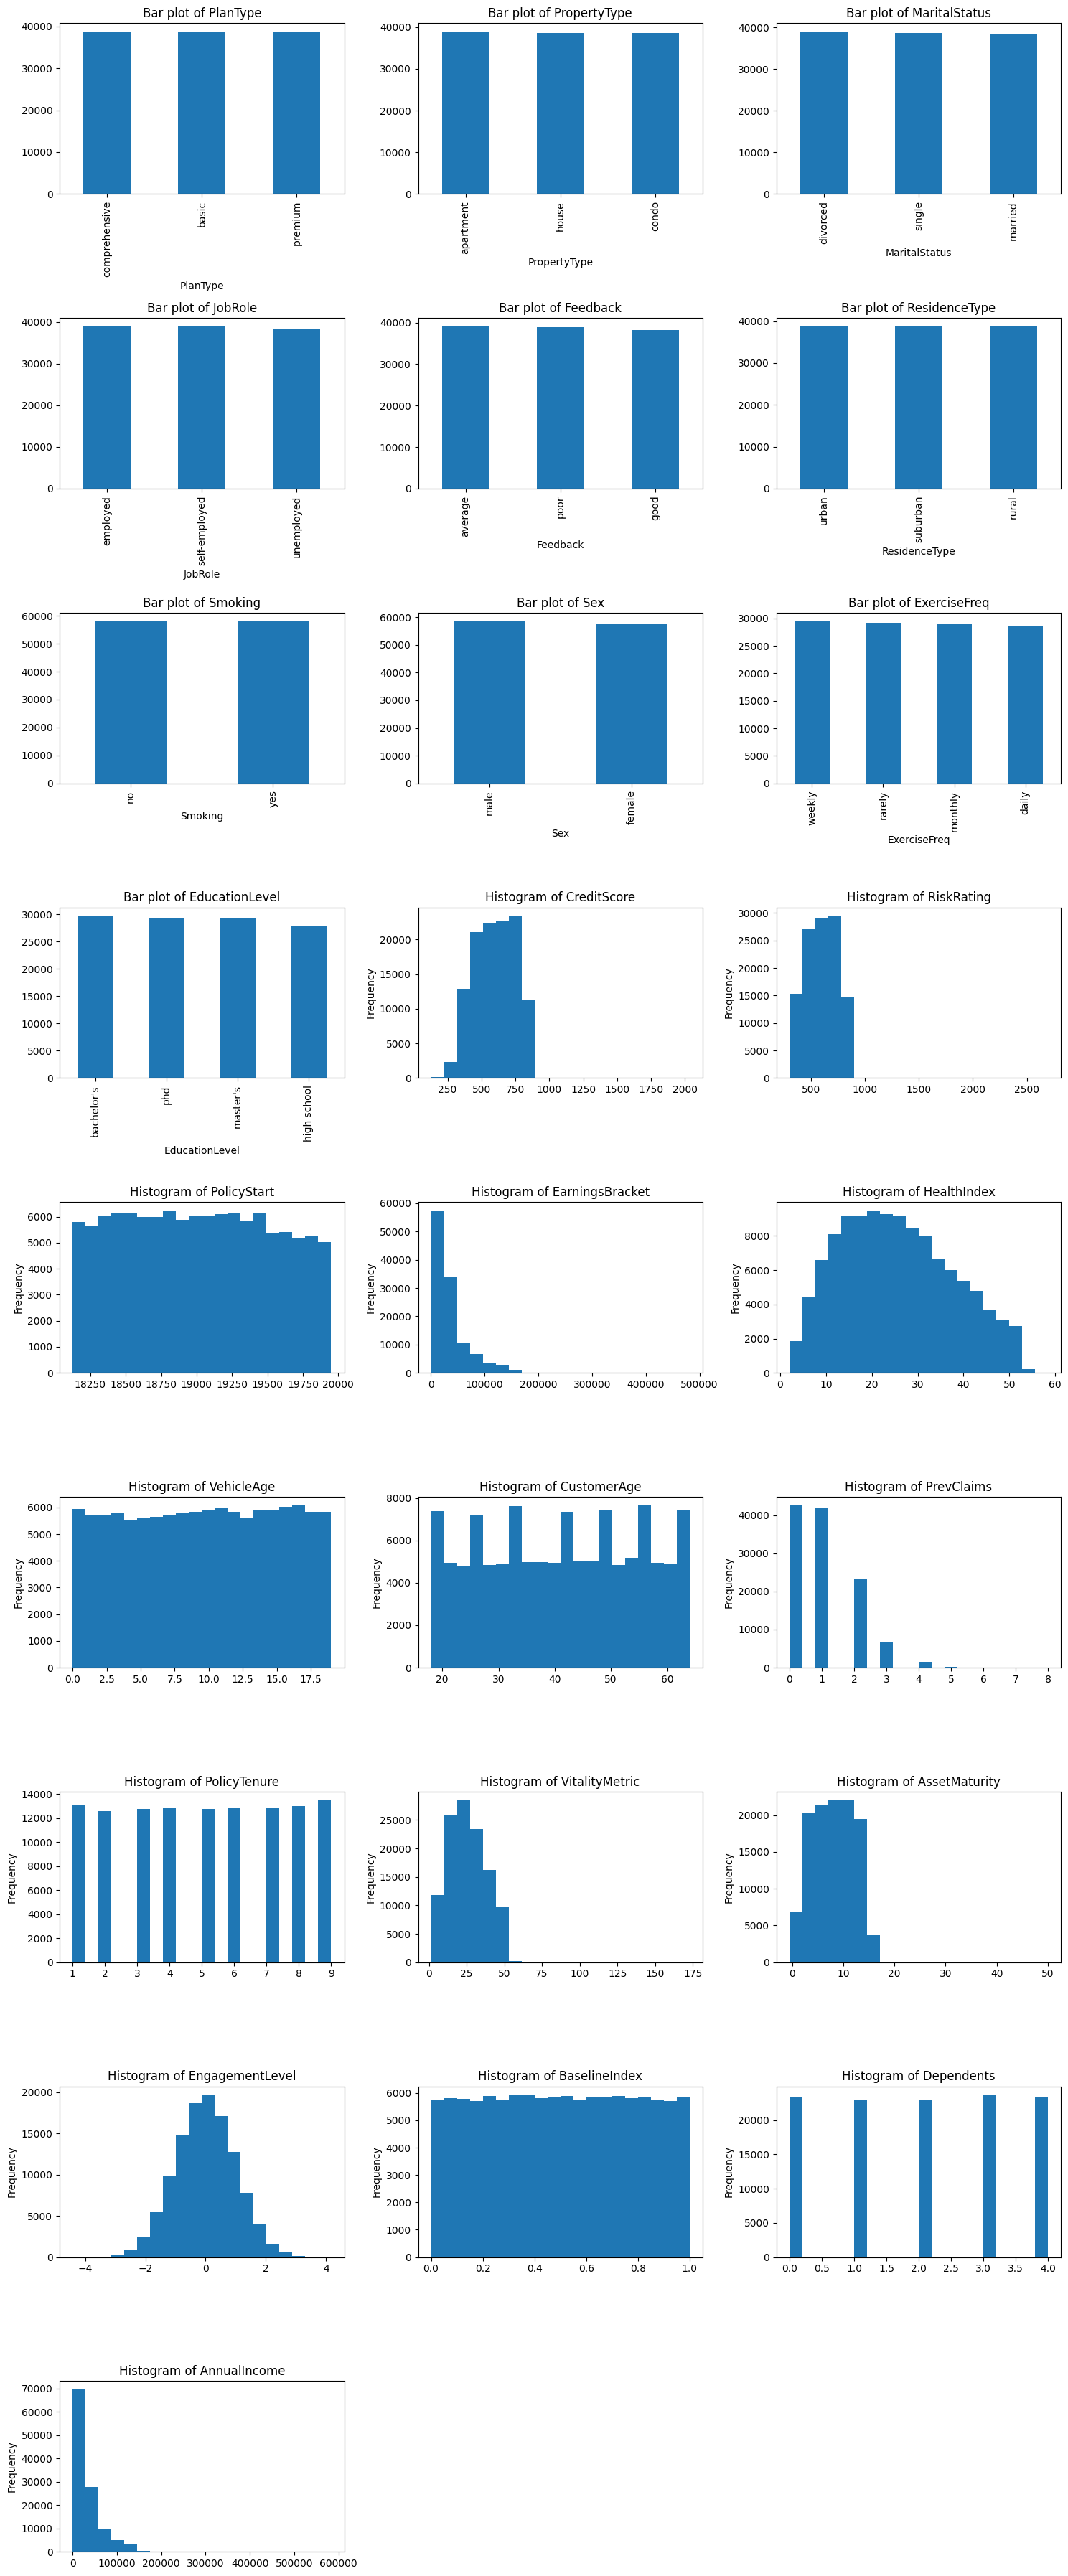

In [31]:
plot_features_grid(
    train_data.drop_nulls().to_pandas(), categorical_features, numeric_features
)

From the looks of it, the dataset looks perfectly balanced in terms of categorical features. Numerics features seem not to have extreme outliers, but features like `AnnualIncome`, `EarningsBracket`.

In [60]:
def plot_features_vs_target(df: pl.DataFrame, numeric_features, target: str):
    n_features = len(numeric_features)

    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    y = df[target].drop_nulls().to_numpy()

    for i, col in enumerate(numeric_features):
        ax = axes[i]
        x = df[col].drop_nulls().to_numpy()
        ax.scatter(x, y[: len(x)], alpha=0.6)
        ax.set_xlabel(col)
        ax.set_ylabel(target)
        ax.set_title(f"{col} vs {target}")

    # Hide unused plots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=2.0, w_pad=1.5, h_pad=1.5)
    plt.show()

I plot the relationshipf of features to target variable. To spot interesting relationships.

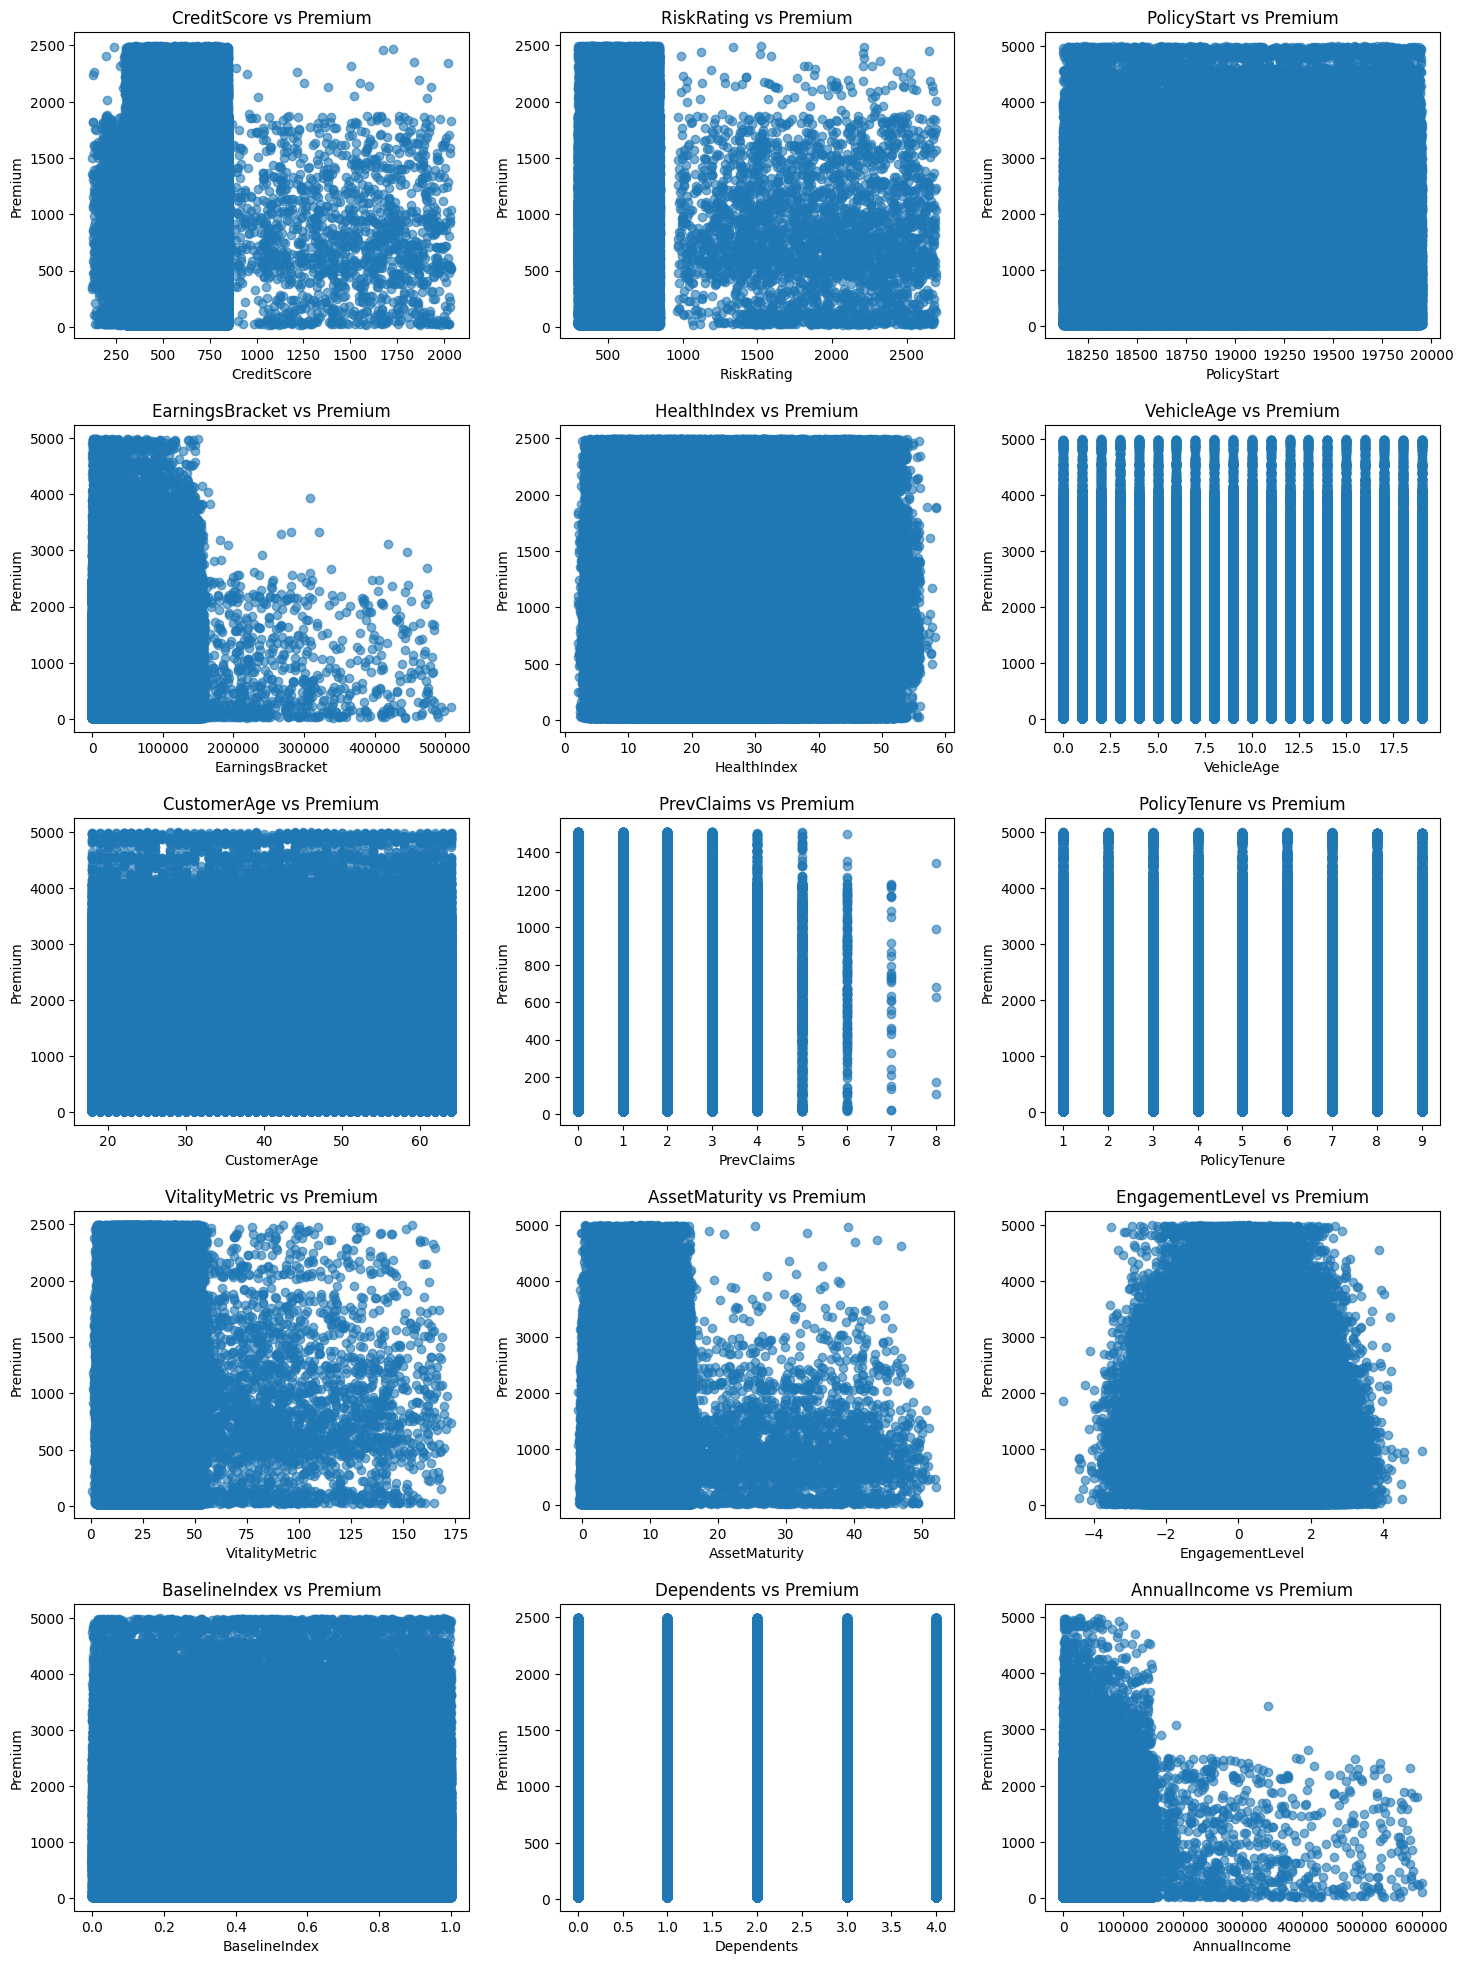

In [61]:
plot_features_vs_target(train_data, numeric_features, target_feature)